# Deep research Multiagent system


### Original doc:

    https://www.youtube.com/watch?v=mjPSkPLbu1s

<div style="width: 100%; height: 768px; overflow: hidden;">
  <iframe width="1024" height="768" src="https://www.youtube.com/embed/mjPSkPLbu1s?si=nrN8Y4pnHNAj-5WZ" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen></iframe>
</div>

In [21]:
%%capture --no-stderr
%pip install -U pip langgraph langchain_community langchain_anthropic langchain-tavily langchain_experimental langchain_ollama mcp langchain-mcp-adapters langchain-google-genai langchain_openai

In [22]:
from dotenv import load_dotenv
import os
# load environment variables from .env file
load_dotenv()
workfolder = os.getenv('WORKFOLDER')
mcp_file_path = os.getenv('MCP_SRV_PATH')
 

In [23]:
from typing import List, Optional, Literal, TypedDict
from langchain_mcp_adapters.client import MultiServerMCPClient
client = MultiServerMCPClient({"mcp": {"command": "python","args": [mcp_file_path], "transport": "stdio", }})
tools = await client.get_tools()
display(tools)

def get_tool(name: str):
    return next((tool for tool in tools if tool.name == name), None)

print(get_tool('web_search'))

[StructuredTool(name='get_current_time', description='Returns current system time.', args_schema={'description': 'Returns current system time.', 'properties': {}, 'title': 'get_current_time', 'type': 'object'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x717fae5d1580>),
 StructuredTool(name='web_search', description='A Internet search engine. Useful for when you need to answer questions about current events', args_schema={'description': 'A Internet search engine. Useful for when you need to answer questions about current events', 'properties': {'query': {'description': 'search query to look up', 'title': 'Query', 'type': 'string'}, 'num_results': {'anyOf': [{'type': 'integer'}, {'type': 'null'}], 'default': 5, 'description': 'Max search results per query to return (default: 5)', 'title': 'Num Results'}}, 'required': ['query'], 'title': 'web_search', 'type': 'object'}, response_format='content_and_artifact', coro

name='web_search' description='A Internet search engine. Useful for when you need to answer questions about current events' args_schema={'description': 'A Internet search engine. Useful for when you need to answer questions about current events', 'properties': {'query': {'description': 'search query to look up', 'title': 'Query', 'type': 'string'}, 'num_results': {'anyOf': [{'type': 'integer'}, {'type': 'null'}], 'default': 5, 'description': 'Max search results per query to return (default: 5)', 'title': 'Num Results'}}, 'required': ['query'], 'title': 'web_search', 'type': 'object'} response_format='content_and_artifact' coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x717fae7c8a40>


In [24]:
from langchain_ollama import ChatOllama
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import ChatOpenAI
from langfuse.langchain import CallbackHandler

llm_model = ChatOllama(model="qwen3")
# llm_model = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0.2)
# llm_model = ChatOpenAI(model="qwen-plus", api_key=os.getenv('DASHSCOPE_API_KEY'), base_url=os.getenv('DASHSCOPE_BASE_URL'))

# Initialize Langfuse CallbackHandler for LangGraph/Langchain (tracing)
langfuse_handler = CallbackHandler() 
llm_config = {"configurable": {"thread_id": "abc123"}, "recursion_limit": 20, "callbacks": [langfuse_handler]}

In [25]:
from langchain.agents import create_agent
from langchain.agents.structured_output import ToolStrategy
from typing import TypedDict

topic_analizer_prompt = """ 
You are a topic analizer. 
Your goal is to generate 4 questions that, together, cover the topic.
output format :
**question 1**:
**question 2**:

"""

# # Define structured output schema
# class TopicAnalysis(TypedDict):
#     topic: str
#     questions: list[str]
    
# Create the agent
topic_analizer = create_agent(name="topic_analizer", model=llm_model, 
    system_prompt=topic_analizer_prompt, 
    # response_format=ToolStrategy(TopicAnalysis)
     )

In [26]:
# # Use the agent
# input_message = {"role": "user", "content": "multi-agent deep research system using langchain in local ollama qwen3"}
# async for step in topic_analizer.astream(
#     {"messages": [input_message]}, llm_config, stream_mode="values"
# ):
#     step["messages"][-1].pretty_print()

In [27]:
from langchain.agents import create_agent
from langchain.agents.structured_output import ToolStrategy
from typing import TypedDict

search_agent_prompt = """ 
You are a Internet search assistant.
Your goal is to find information from web search.
Get 2 results for a given query string. 
Do not elaborate, do not ask any questions
1. Optimize the query string before search on the Internet
2. output format:
**url 1**:
**url 2**:
"""

# # Define structured output schema
# class SearchItem(TypedDict):
#     href: str
#     # title: str
#     # body: str

# class SearchFormat(TypedDict):
#     summary: str
#     # results: list[SearchItem]
    
# Create the agent
search_agent = create_agent(name="search_agent", model=llm_model, tools=[get_tool('web_search')], 
    system_prompt=search_agent_prompt, 
    # response_format=ToolStrategy(SearchFormat)
    )


In [28]:

input_message = {"role": "user", "content": """**question 1**:  
What are the key components and architecture required to build a multi-agent deep research system using LangChain and Ollama's Qwen3 model?"""
}

# # Use the agent
# async for step in search_agent.astream(
#     {"messages": [input_message]}, llm_config, stream_mode="values"
# ):
#     step["messages"][-1].pretty_print()

In [29]:
from langchain.agents import create_agent

# Create the agent
summarization_agent_prompt = """ 
You are a summarization assistant 
1. For each url scrape the web pages for detailed information.
2. Summarize each source in 2-4 concise bullet points.
2. output format:
**url 1**:
**summary**:
**url 2**:
**summary**:
"""
summarization_agent = create_agent(name="summarization_agent", model=llm_model, tools=[get_tool('scrape_webpages')], system_prompt=summarization_agent_prompt)

In [30]:
input_message = {"role": "user", "content": """**url 1**:  
https://composio.dev/blog/deep-research-agent-qwen3-using-langgraph-and-ollama  
**url 2**:  
https://www.freecodecamp.org/news/build-a-local-ai/  """
  }

# # Use the agent
# async for step in summarization_agent.astream(
#     {"messages": [input_message]}, llm_config, stream_mode="values"
# ):
#     step["messages"][-1].pretty_print()

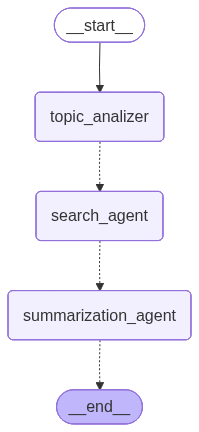

In [31]:
from typing import List, Optional, Literal, TypedDict
from langchain_core.language_models.chat_models import BaseChatModel
from IPython.display import Image, display
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage, trim_messages


class State(MessagesState):
    next: str

async def make_supervisor_node(llm: BaseChatModel, members: list[str]) -> str:
    options = ["FINISH"] + members

    class Router(TypedDict):
        """Worker to route to next. If no workers needed, route to FINISH."""
        next: Literal[*options]

    supervisor_system_prompt = f"""
You are a supervisor tasked with managing a conversation between the following workers: {members}. 
Given the following user request, respond with the worker to act next. 
Break multiple lines outputs into single separate items requests to the workers. 
Each worker will perform a task and respond with their results. 
When finished, respond with FINISH. /think"""

    async def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
        """An LLM-based router."""
        messages = [ {"role": "system", "content": supervisor_system_prompt},] + state["messages"]
        response = await llm.with_structured_output(Router).ainvoke(messages)
        goto = response["next"]
        if goto == "FINISH":
            goto = END

        return Command(
            update={"next": goto},
            goto=goto, 
            )

    return supervisor_node


async def topic_analizer_node(state: State) -> Command[Literal["search_agent"]]:
    result = await topic_analizer.ainvoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="topic_analizer")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="search_agent",
    )

async def search_agent_node(state: State) -> Command[Literal["summarization_agent"]]:
    result = await search_agent.ainvoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="search_agent")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="summarization_agent",
    )

async def summarization_agent_node(state: State) -> Command[Literal["__end__"]]:
    result = await summarization_agent.ainvoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="summarization_agent")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="__end__",
    )

research_builder = StateGraph(State)

# research_supervisor_node = await make_supervisor_node(llm_model, ["topic_analizer", "search_agent", "summarization_agent"])
# research_builder.add_edge(START, "supervisor")
# research_builder.add_node("supervisor", research_supervisor_node)
# research_builder.add_node("topic_analizer", topic_analizer_node)
# research_builder.add_node("search_agent", search_agent_node)
# research_builder.add_node("summarization_agent", summarization_agent_node)

research_builder.add_edge(START, "topic_analizer")
research_builder.add_node("topic_analizer", topic_analizer_node)
research_builder.add_node("search_agent", search_agent_node)
research_builder.add_node("summarization_agent", summarization_agent_node)


research_graph = research_builder.compile()
display(Image(research_graph.get_graph().draw_mermaid_png()))

In [32]:
messages = {"messages": [("user", "multi-agent deep research system using langchain in local ollama qwen3")]}
async for step in research_graph.astream(messages, config=llm_config, stream_mode="values" ):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

multi-agent deep research system using langchain in local ollama qwen3
================================ Human Message =================================
Name: topic_analizer

<think>
Okay, the user is asking about a multi-agent deep research system using LangChain with local Ollama and Qwen3. Let me break down what they need. First, I should figure out the key components here. Multi-agent systems involve multiple AI agents working together, so I need to cover how they interact. LangChain is for building applications with LLMs, so maybe questions about integrating LangChain with Ollama. Ollama is a local LLM runtime, so using it with Qwen3, which is a model from Alibaba. 

The user might be looking to set up a local environment for research. So questions about setting up the local environment with Ollama and Qwen3. Then, how to structure the agents—like roles, communication protocols. Also, how to handle co

In [ ]:
llm = ChatOllama(model="qwen3")

doc_writer_agent = create_react_agent(
    llm,
    tools=[write_file, edit_document, read_file],
    prompt=(
        "You can read, write and edit documents based on note-taker's outlines. "
        "Don't ask follow-up questions."
    ),
)


def doc_writing_node(state: State) -> Command[Literal["supervisor"]]:
    result = doc_writer_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="doc_writer")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


note_taking_agent = create_react_agent(
    llm,
    tools=[create_outline, read_file],
    prompt=(
        "You can read documents and create outlines for the document writer. "
        "Don't ask follow-up questions."
    ),
)


def note_taking_node(state: State) -> Command[Literal["supervisor"]]:
    result = note_taking_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="note_taker")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


chart_generating_agent = create_react_agent(
    llm, tools=[read_file, python_repl_tool]
)


def chart_generating_node(state: State) -> Command[Literal["supervisor"]]:
    result = chart_generating_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=result["messages"][-1].content, name="chart_generator"
                )
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


doc_writing_supervisor_node = make_supervisor_node(
    llm, ["doc_writer", "note_taker", "chart_generator"]
)

With the objects themselves created, we can form the graph.

In [ ]:
# Create the graph here
paper_writing_builder = StateGraph(State)
paper_writing_builder.add_node("supervisor", doc_writing_supervisor_node)
paper_writing_builder.add_node("doc_writer", doc_writing_node)
paper_writing_builder.add_node("note_taker", note_taking_node)
paper_writing_builder.add_node("chart_generator", chart_generating_node)

paper_writing_builder.add_edge(START, "supervisor")
paper_writing_graph = paper_writing_builder.compile()

In [ ]:
from IPython.display import Image, display

display(Image(paper_writing_graph.get_graph().draw_mermaid_png()))

In [ ]:
# for s in paper_writing_graph.stream(
#     {
#         "messages": [
#             (
#                 "user",
#                 "Write an outline for poem about cats and then write the poem to disk.",
#             )
#         ]
#     },
#     {"recursion_limit": 100, "callbacks": [langfuse_handler]},
# ):
#     print(s)
#     print("---")

## Add Layers

In this design, we are enforcing a top-down planning policy. We've created two graphs already, but we have to decide how to route work between the two.

We'll create a _third_ graph to orchestrate the previous two, and add some connectors to define how this top-level state is shared between the different graphs.

In [ ]:
from langchain_core.messages import BaseMessage

teams_supervisor_node = make_supervisor_node(llm, ["research_team", "writing_team"])

In [ ]:
def call_research_team(state: State) -> Command[Literal["supervisor"]]:
    response = research_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="research_team"
                )
            ]
        },
        goto="supervisor",
    )


def call_paper_writing_team(state: State) -> Command[Literal["supervisor"]]:
    response = paper_writing_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="writing_team"
                )
            ]
        },
        goto="supervisor",
    )


# Define the graph.
super_builder = StateGraph(State)
super_builder.add_node("supervisor", teams_supervisor_node)
super_builder.add_node("research_team", call_research_team)
super_builder.add_node("writing_team", call_paper_writing_team)

super_builder.add_edge(START, "supervisor")
super_graph = super_builder.compile()

In [ ]:
from IPython.display import Image, display

display(Image(super_graph.get_graph().draw_mermaid_png()))

In [ ]:
for s in super_graph.stream(
    {
        "messages": [
            ("user", "Research AI agents and write in a file using the writing_team a brief report about them.")
        ],
    },
    {"recursion_limit": 150, "callbacks": [langfuse_handler]},
):
    print(s)
    print("---")